# Quick check
- Take DST, correct the energy
- Find the e_raw for double escpae peak
- Set cut for the zero supressed data to be above this.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

import sys,os,os.path
sys.path.append("/gluster/data/next/software/IC_311024/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_311024/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm

import functions_HE as func

%load_ext autoreload
%autoreload 2

In [2]:
RUN_NUMBER = 15107
TIMESTAMP  = 140425

In [3]:
n100_dir = f'/gluster/data/next/files/TOPOLOGY_John/N100_data/{RUN_NUMBER}/sophronia/trigger2/'

full_dst_norebin = []

for i in tqdm(range(1, 8)):

    print(f"LDC {i}")
    folder_path = n100_dir + 'ldc' + str(i) + '/'
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]
    
    full_dst_norebin.append(load_dsts([folder_path + x for x in file_names], 'DST', 'Events'))

full_dst_norebin = pd.concat(full_dst_norebin)

  0%|          | 0/7 [00:00<?, ?it/s]

LDC 1


 14%|█▍        | 1/7 [01:51<11:11, 111.95s/it]

LDC 2


 29%|██▊       | 2/7 [03:37<08:59, 107.96s/it]

LDC 3


 43%|████▎     | 3/7 [05:21<07:04, 106.18s/it]

LDC 4


 57%|█████▋    | 4/7 [07:54<06:13, 124.60s/it]

LDC 5


 71%|███████▏  | 5/7 [14:42<07:33, 226.96s/it]

LDC 6


 86%|████████▌ | 6/7 [17:17<03:22, 202.52s/it]

LDC 7


100%|██████████| 7/7 [19:10<00:00, 164.36s/it]


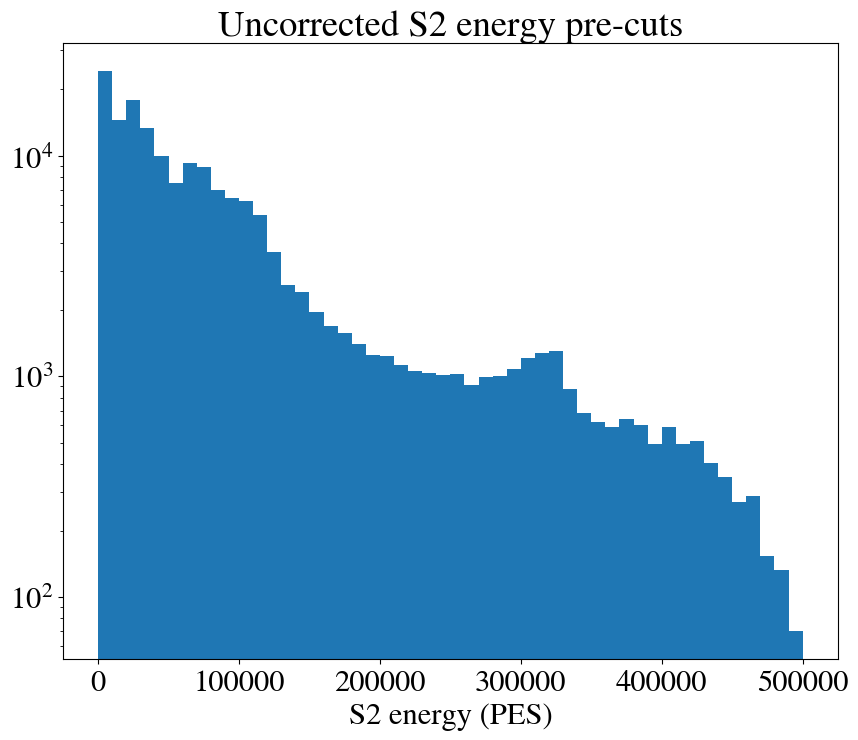

In [5]:
plt.hist(full_dst_norebin.S2e.values, bins = 50, range = (0, 500000))
plt.title('Uncorrected S2 energy pre-cuts')
plt.yscale('log')
plt.xlabel('S2 energy (PES)')
plt.show()


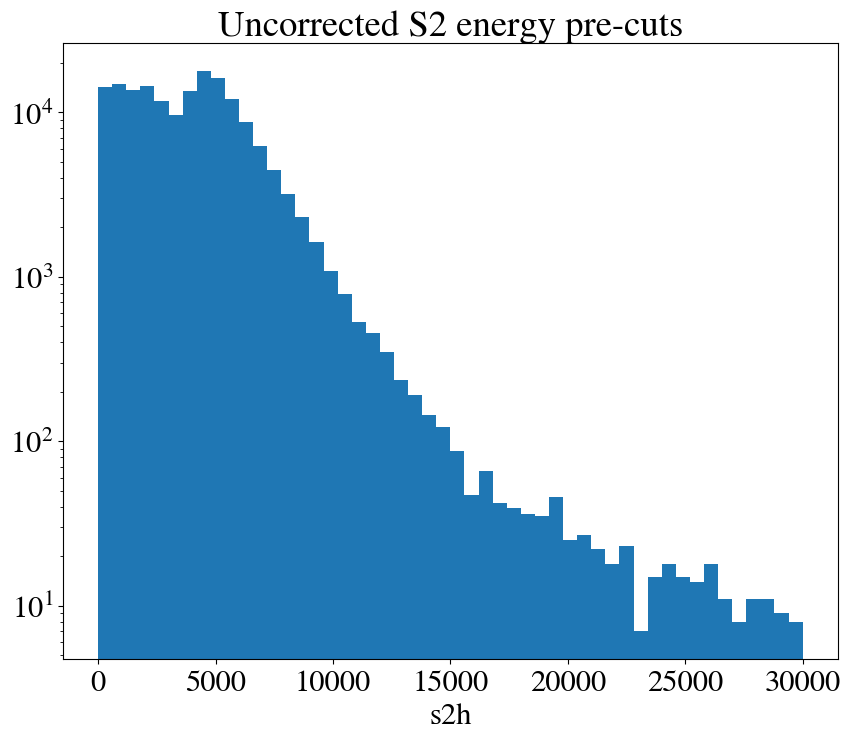

: 

In [ ]:
plt.hist(full_dst_norebin.S2h.values, bins = 50, range = (0, 30000))
plt.title('Uncorrected S2 energy pre-cuts')
plt.yscale('log')
plt.xlabel('s2h')
plt.show()


In [7]:
def hits_corrector( filename   : str
                  , apply_temp : bool
                  , norm_strat : NormStrategy
                  , norm_value : Optional[Union[float, NoneType]] = None
                  ) -> Callable:
    """
    Applies energy correction map and converts drift time to z.

    Parameters
    ----------
    map_fname  : string (filepath)
        filename of the map
    apply_temp : bool
        whether to apply temporal corrections
        must be set to False if no temporal correction dataframe exists in map file

    Returns
    ----------
    A function that takes a HitCollection as input and returns
    the same object with modified Ec and Z fields.
    """

    if ( ((norm_strat is not NormStrategy.custom)  ^  (norm_value is None)) or
          (norm_strat is     NormStrategy.custom) and (norm_value<= 0)):
        raise ValueError(
            "`NormStrategy.custom` requires `norm_value` to be greater than 0. "
            "For all other `NormStrategy` options, `norm_value` must not be provided."
        )

    maps      = read_maps(os.path.expandvars(filename))
    get_coef  = apply_all_correction( maps
                                    , apply_temp = apply_temp
                                    , norm_strat = norm_strat
                                    , norm_value = norm_value)
    time_to_Z = get_df_to_z_converter(maps) if maps.t_evol is not None else identity

    def correct(hitc : HitCollection) -> HitCollection:
        for hit in hitc.hits:
            corr    = get_coef([hit.X], [hit.Y], [hit.Z], hitc.time)[0]
            hit.Ec  = hit.E * corr
            hit.xyz = (hit.X, hit.Y, time_to_Z(hit.Z)) # ugly, but temporary
        return hitc

    return correct

In [ ]:

corrector = hits_corrector('/gluster/data/next/files/TOPOLOGY_John/LPR/LightTables/map_4bar_15063.h5',
                           True,
                           NormStrategy.kr)

corrected_RECO = []

for i, df in tqdm(r.groupby('event')):
    #print(i)
    #display(df)
    hitc = hits_from_df(df)
    key = list(hitc.keys())[0]
    correct_hitc = corrector(hitc[key])
    corrected_RECO.append(hitc_to_df_(correct_hitc))
    
corrected_RECO = pd.concat(corrected_RECO)
'''
maps      = read_maps(os.path.expandvars('/gluster/data/next/files/TOPOLOGY_John/LPR/LightTables/map_4bar_15063.h5'))
get_coef  = apply_all_correction( maps
                                , apply_temp = True
                                , norm_strat = NormStrategy.kr)



# ^^^ This shit was too slow, so have to rewrite the logic to apply to a full df
#coefs = get_coef(r.)
'''

# dummy! you already have events within the corrected DEP, lets go collect em

In [ ]:
folder_path = 'files/15107_energy_split/'
corr_DES = pd.read_hdf(folder_path + 'corr_DES.h5', 'RECO/Events')

: 

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
28970,1127289,1.742950e+09,0,147.268254,84.815097,1,-343.675,-185.975,0.0,0.0,626.325625,5.457119,3.347841,-1.0,0.000018,-1,-1.0
28971,1127289,1.742950e+09,0,147.268254,84.815097,1,-343.675,184.225,0.0,0.0,626.325625,9.765893,5.991194,-1.0,0.000032,-1,-1.0
28972,1127289,1.742950e+09,0,147.268254,84.815097,1,-265.925,168.675,0.0,0.0,626.325625,5.613680,3.443889,-1.0,0.000018,-1,-1.0
28973,1127289,1.742950e+09,0,147.268254,84.815097,1,-189.175,152.625,0.0,0.0,626.325625,5.255363,3.224068,-1.0,0.000016,-1,-1.0
28974,1127289,1.742950e+09,0,147.268254,84.815097,1,-34.675,-386.625,0.0,0.0,626.325625,5.230516,3.208825,-1.0,0.000017,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30568968,967777,1.742948e+09,0,40.029658,-169.915785,1,-126.975,-309.875,0.0,0.0,609.824750,5.649685,6.021073,-1.0,0.000032,-1,-1.0
30568969,967777,1.742948e+09,0,40.029658,-169.915785,1,-34.675,-263.225,0.0,0.0,609.824750,6.475501,6.901175,-1.0,0.000035,-1,-1.0
30568970,967777,1.742948e+09,0,40.029658,-169.915785,1,42.075,430.525,0.0,0.0,609.824750,6.036242,6.433040,-1.0,0.000037,-1,-1.0
30568971,967777,1.742948e+09,0,40.029658,-169.915785,1,396.725,168.675,0.0,0.0,609.824750,5.916093,6.304994,-1.0,0.000035,-1,-1.0


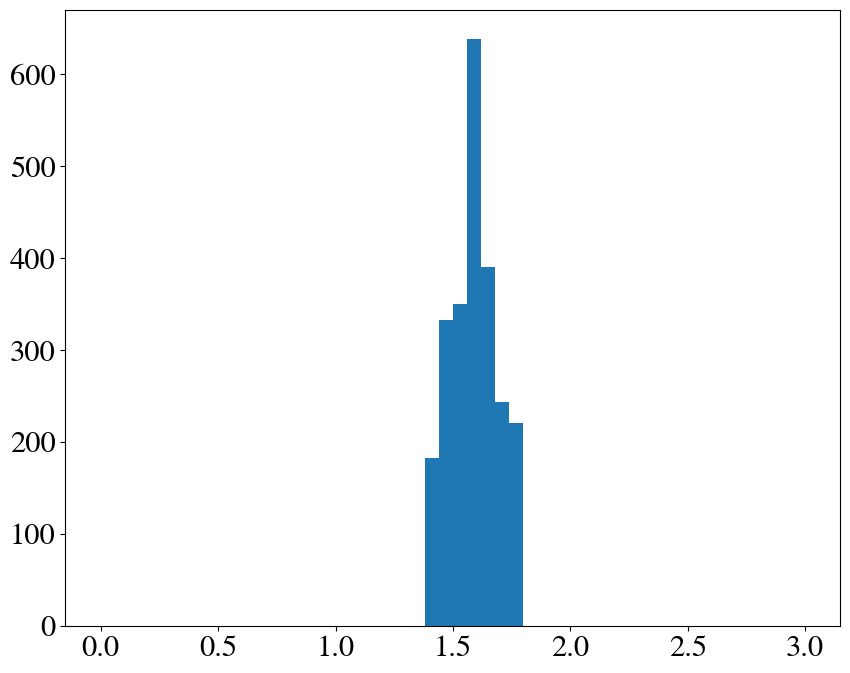

: 

In [ ]:
display(corr_DES)
plt.hist(corr_DES.groupby('event').Ec.sum(), bins = 50, range = (0, 3))
plt.show()

# extract the DEP events from the DST and check s2h and s2e

In [ ]:
DEP_DST = full_dst_norebin[full_dst_norebin.event.isin(corr_DES.event.unique())]
display(DEP_DST)

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
14,590,1.742935e+09,0,0,1,1,400.0,41.841473,240.074432,1139325.0,...,2969,266.157379,266.157379,29.010471,170.053074,19.509000,171.168482,0.114224,217.766683,168.386432
89,3698,1.742935e+09,0,0,1,1,650.0,77.130600,426.490875,638725.0,...,3427,772.762939,772.762939,58.251855,69.109580,118.162832,136.888966,1.041578,210.940452,222.299077
180,827423,1.742946e+09,0,0,1,1,325.0,51.427891,302.451202,756775.0,...,3015,690.708923,690.708923,25.792652,-36.133099,8.602844,37.143099,2.907857,179.844949,171.202828
202,1183723,1.742950e+09,0,0,1,1,600.0,53.805336,302.228516,886600.0,...,3332,534.887634,534.887634,43.368691,-148.885012,39.500449,154.035815,2.882259,252.993341,187.206684
211,781937,1.742945e+09,0,0,1,1,325.0,61.459637,343.489380,308300.0,...,3124,1114.193848,1114.193848,33.659910,44.736161,130.706335,138.150172,1.241029,183.175907,207.274330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24898,1405109,1.742953e+09,0,0,1,1,550.0,39.005119,218.444077,1324350.0,...,3174,128.138382,128.138382,39.892258,-53.246427,178.673593,186.438823,1.860426,194.553234,234.029476
24911,1438982,1.742954e+09,0,0,1,1,325.0,52.862793,287.176605,1055475.0,...,3220,360.006134,360.006134,46.104074,146.076459,166.646797,221.606604,0.851082,217.781610,226.090606
25130,1204608,1.742951e+09,0,0,1,1,375.0,51.238728,294.252930,599675.0,...,3055,766.807678,766.807678,33.815285,-164.629058,-45.844042,170.892958,-2.870004,250.242923,190.233481
25131,1204930,1.742951e+09,0,0,1,1,575.0,52.121933,295.291199,659500.0,...,3510,734.986938,734.986938,88.055328,125.191215,105.517228,163.727596,0.700328,251.608241,231.290444


: 

In [ ]:
print(DEP_DST.columns.values)

['event' 'time' 's1_peak' 's2_peak' 'nS1' 'nS2' 'S1w' 'S1h' 'S1e' 'S1t'
 'S2w' 'S2h' 'S2e' 'S2q' 'S2t' 'qmax' 'Nsipm' 'DT' 'Z' 'Zrms' 'X' 'Y' 'R'
 'Phi' 'Xrms' 'Yrms']


: 

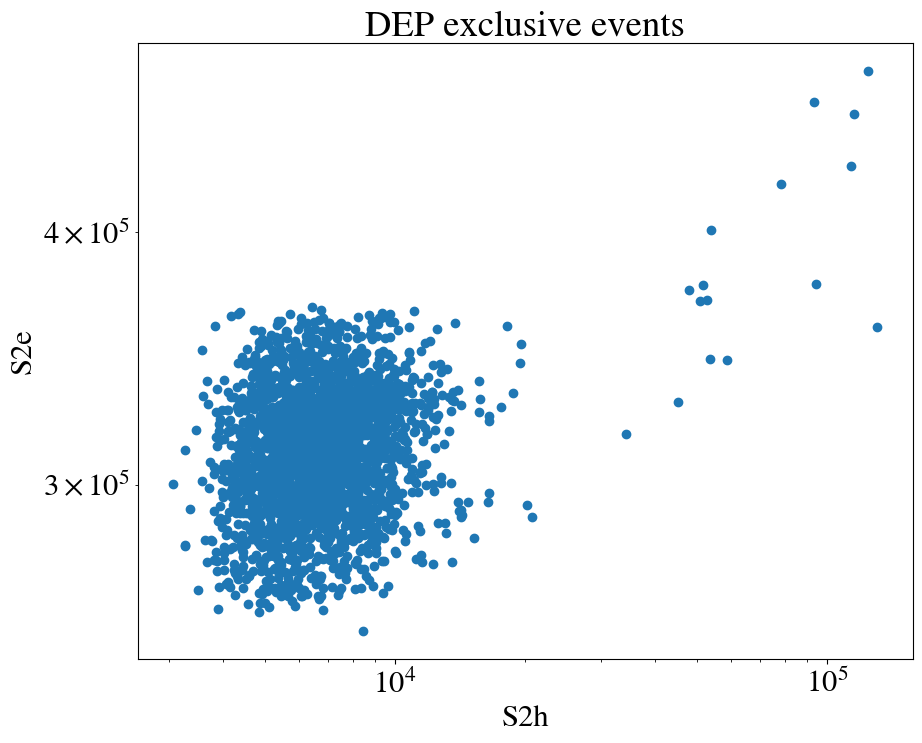

: 

In [ ]:
plt.scatter(DEP_DST.S2h.values, DEP_DST.S2e.values)
plt.xlabel('S2h')
plt.ylabel('S2e')
plt.title('DEP exclusive events')
plt.xscale('log')
plt.yscale('log')
plt.show()

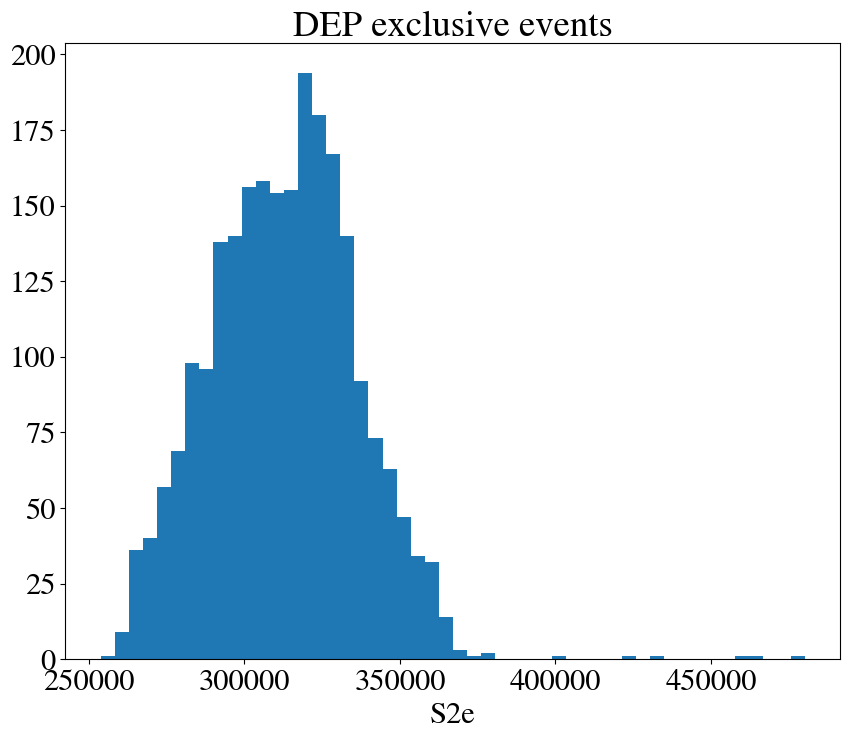

: 

In [ ]:
plt.hist(DEP_DST.S2e.values, bins = 50)
plt.xlabel('S2e')
plt.title('DEP exclusive events')
plt.show()

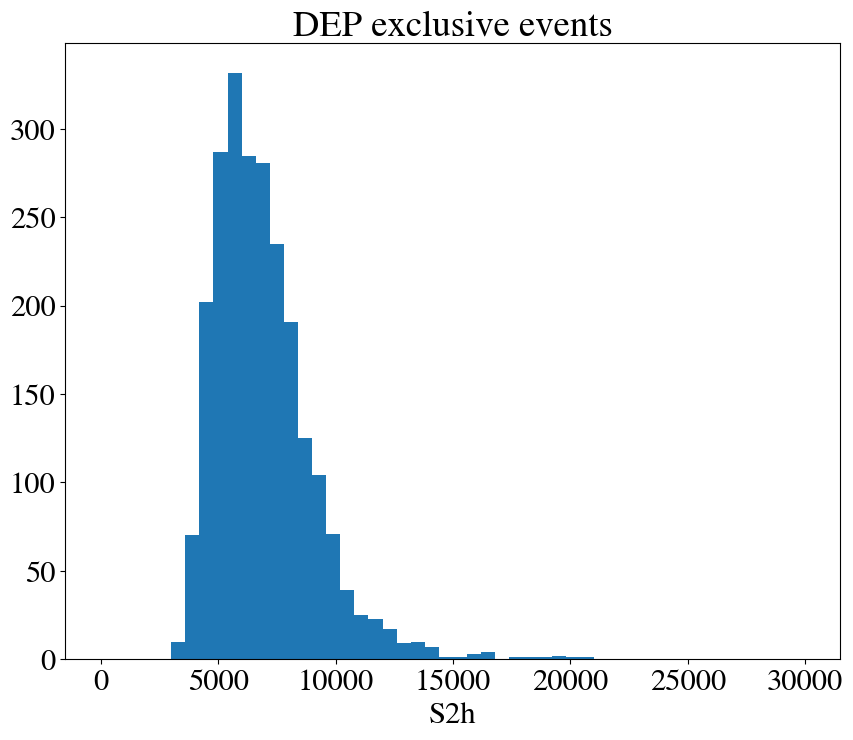

In [20]:
plt.hist(DEP_DST.S2h.values, bins = 50, range = (0, 30000))
plt.xlabel('S2h')
plt.title('DEP exclusive events')
plt.show()

but this is only the DEP, how about events beyond the compton edge?

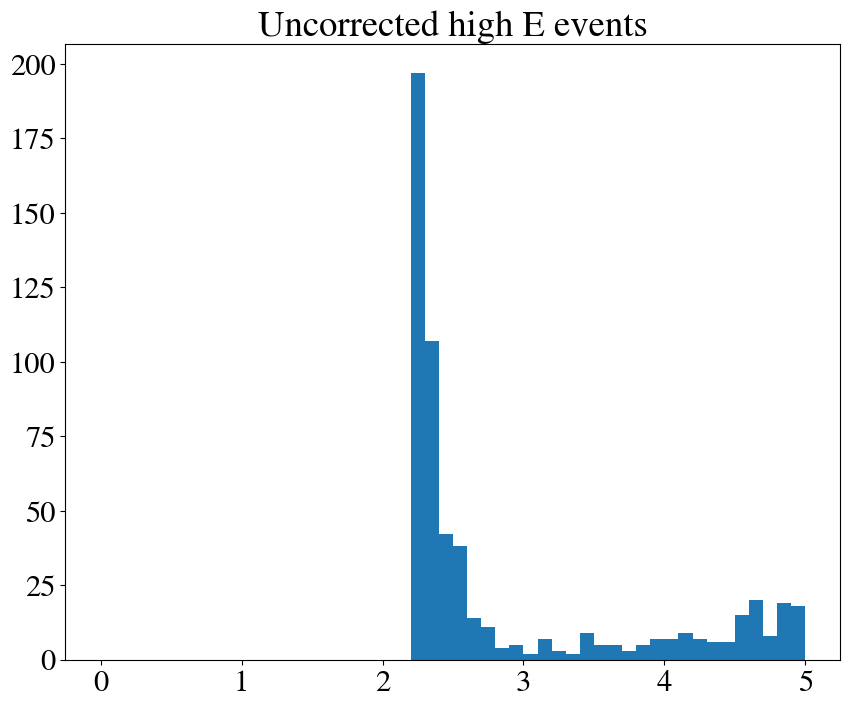

In [15]:
soph_file = 'files/15107_energy_split/corr_post_CE.h5'
post_CE = pd.read_hdf(soph_file, key = 'RECO/Events')

plt.hist(post_CE.groupby('event').Ec.sum(), bins = 50, range = [0, 5])
plt.title('Uncorrected high E events')
plt.show()

In [16]:
PCE_DST = full_dst_norebin[full_dst_norebin.event.isin(post_CE.event.unique())]
display(PCE_DST)

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
55,2767,1.742935e+09,0,0,1,1,325.0,77.264076,437.965027,788900.0,...,3260,622.585022,622.585022,29.934578,-160.956322,-11.514155,161.367634,-3.070178,247.153361,179.804141
610,1391245,1.742953e+09,0,0,1,1,750.0,87.237572,494.402161,648950.0,...,3362,774.530762,774.530762,31.925961,79.838870,39.451447,89.054263,0.458947,193.469571,181.889363
1112,1314567,1.742952e+09,0,0,1,1,725.0,163.414886,926.556946,1120800.0,...,3223,289.686768,289.686768,3.565910,-194.932427,2.809247,194.952668,3.127182,256.774538,174.667868
1498,281241,1.742939e+09,0,0,1,1,350.0,242.169983,1403.406860,44650.0,...,3316,1373.835205,1373.835205,7.876797,7.243044,-17.398684,18.846111,-1.176319,165.465168,163.403332
1714,1268542,1.742951e+09,0,0,1,1,325.0,109.275208,622.064758,350025.0,...,3376,1063.460327,1063.460327,48.793715,-39.991964,-40.904445,57.206038,-2.344915,185.572821,180.992198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23520,1264381,1.742951e+09,0,0,1,1,1150.0,50.444542,1502.908569,44575.0,...,3319,1373.914429,1373.914429,7.846483,-8.695603,-127.871557,128.166878,-1.638694,166.084876,196.467484
23741,483391,1.742941e+09,0,0,1,1,325.0,229.064484,1261.994629,40675.0,...,3315,1375.813477,1375.813477,7.898234,53.321632,250.875162,256.479129,1.361370,160.996053,246.037841
24077,859347,1.742946e+09,0,0,1,1,325.0,85.191910,492.520355,525050.0,...,3378,895.435913,895.435913,41.156488,85.637696,152.697139,175.072075,1.059674,195.789319,245.635698
24492,1474451,1.742954e+09,0,0,1,1,775.0,61.017853,1484.981567,43700.0,...,3331,1374.790405,1374.790405,7.862756,-105.928456,-114.571925,156.037059,-2.317015,184.519079,185.674290


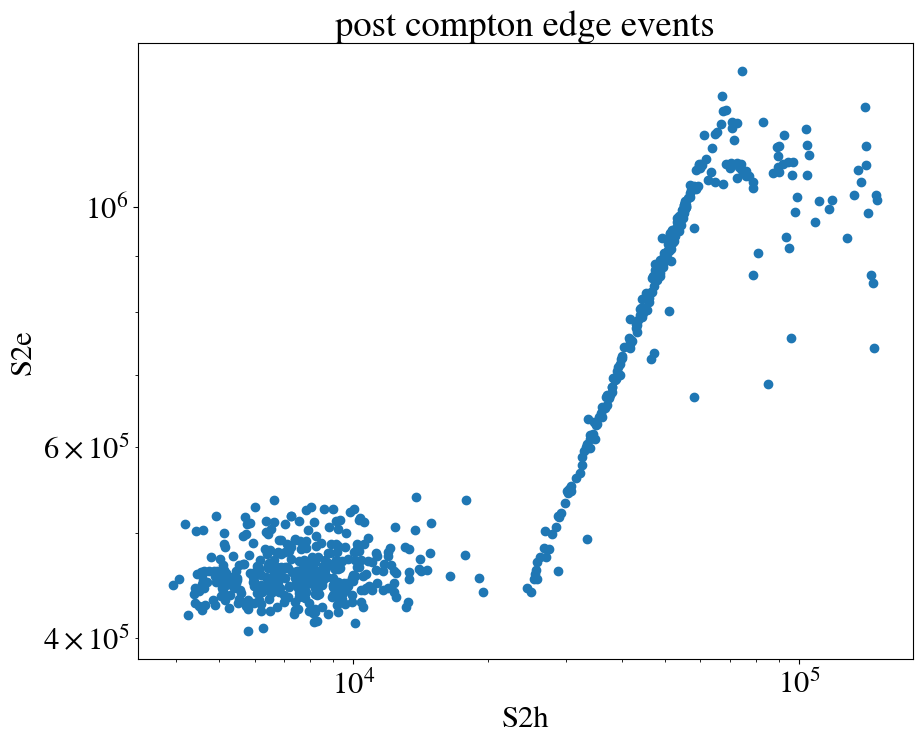

In [17]:
plt.scatter(PCE_DST.S2h.values, PCE_DST.S2e.values)
plt.xlabel('S2h')
plt.ylabel('S2e')
plt.title('post compton edge events')
plt.xscale('log')
plt.yscale('log')
plt.show()

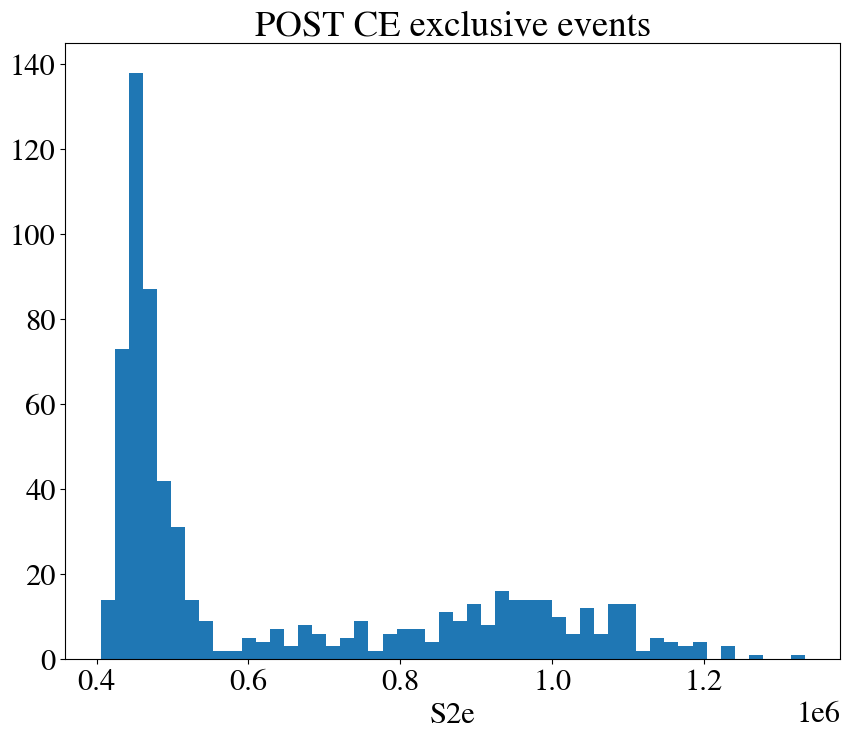

In [18]:
plt.hist(PCE_DST.S2e.values, bins = 50)
plt.xlabel('S2e')
plt.title('POST CE exclusive events')
plt.show()

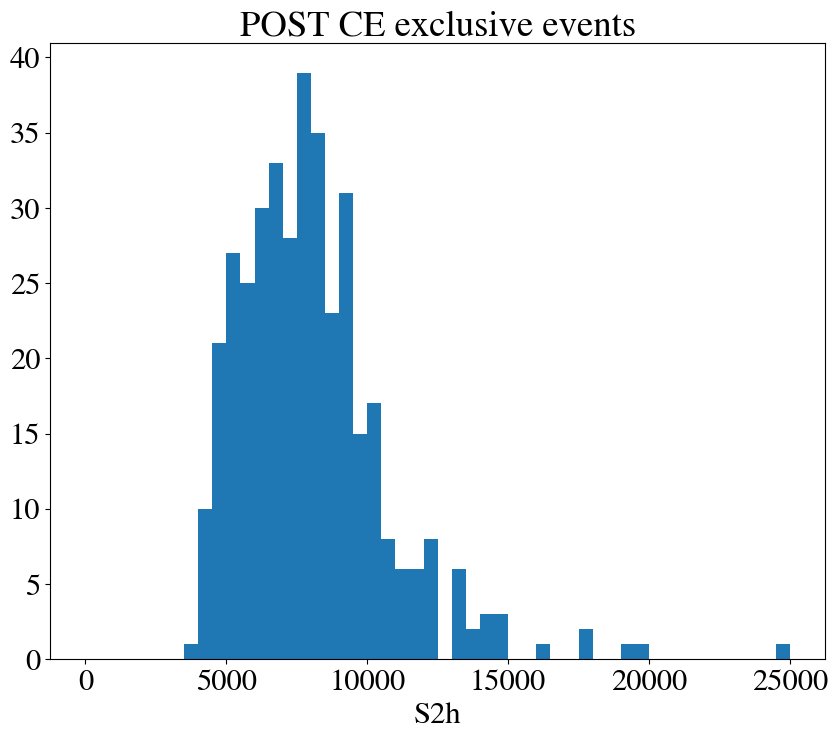

In [22]:
plt.hist(PCE_DST.S2h.values, bins = 50, range = (0, 25000))
plt.xlabel('S2h')
plt.title('POST CE exclusive events')
plt.show()